# **CS224W: Final Project**
# Graph WaveNet for Deep Spatial-Temporal Graph Modeling

Spatial-temporal graph modeling is a technique used to analyze and understand complex systems, particularly those with varying behaviors across both spatial (how different components or nodes are related in space) and temporal (how these relationships change over time) dimensions. With the advent of graph neural networks, spatial-temporal graph modeling has received increased attention due to its applicability in diverse problem spaces, encompassing areas like traffic speed forecasting, taxi demand prediction, human action recognition, and more.

However, capturing spatial and temporal dependencies simultaneously can be challenging. Recent research has explored integrating graph convolution networks (GCN) into either a recurrent neural network (RNN) or a convolutional neural network (CNN). However, these approaches have drawbacks. The GCN assumes that the predefined graph structure accurately represents genuine dependency relationships, overlooking nuanced situations where connections do not imply true inter-dependencies. Also, capturing temporal dependencies with RNNs or CNNs can be slow and computationally inefficient when considering longer sequences. 

We introduce the Graph WaveNet framework to tackle these shortcomings and effectively represent Spatial-temporal graphs using Graph Wavenet Framework to forecast the future.

# Installation

In [53]:
# Install torch geometric
import os
import torch
torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip3 install torch-scatter -f $scatter_src
!pip3 install torch-sparse -f $sparse_src
!pip3 install torch-geometric
!pip3 install -q git+https://github.com/snap-stanford/deepsnap.git
!pip3 install -U -q PyDrive

!python3 -c "import torch; print(torch.version.cuda)"

Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1.html

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1.html

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
None


In [54]:
import torch
print(torch.__version__)
import torch_geometric
print(torch_geometric.__version__)

1.13.1
2.4.0


## Graph WaveNet Framework - Our Implementation
Our implementation of Graph WaveNet Framework is located at https://github.com/ggaoshen/graph_wavenet.git. We import the `GraphWaveNet` model from our repo and load it to the Colab.

In [ ]:
# Import GraphWaveNet module
!git clone https://github.com/ggaoshen/graph_wavenet.git
%load graph_wavenet/src/graphwavenet.py
import sys
sys.path.append('graph_wavenet/src/')
from graphwavenet import GraphWaveNet
import util as util
from util import masked_rmse, masked_mse, masked_mae, masked_mape, metric

## PyTorch Geometric Temporal
PyTorch Geometric Temporal is a temporal graph neural network extension library for PyTorch Geometric. It builds on open-source deep-learning and graph processing libraries. It is the first open-source library for temporal deep learning on geometric structures and provides constant time difference graph neural networks on dynamic and static graphs.
We install the PGT library to gain access to its strucures, functions and datasets.

In [5]:
!pip3 install -U torch-geometric-temporal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 25.2 MB/s eta 0:00:00
  Created wheel for torch-geometric-temporal: filename=torch_geometric_temporal-0.54.0-py3-none-any.whl size=86722 sha256=4ffae596d28417b183e4fa11a37ab17ff4dffc39a91baff505458626fee2db25
  Stored in directory: /root/.cache/pip/wheels/9e/9b/b6/e15256e053f0cb49b1084a67a709db909d418386a231f0722c
Successfully built torch-geometric-temporal
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires pyth

## Hungarian Chickenpox Dataset
PyTorch Geometric Temporal (PGT) provides the Chickenpox Cases in Hungary dataset, which shares the reported cases of chickenpox in Hungary by county on a weekly basis between 2005 and 2015, with (20) nodes representing counties and (61) undirected edges representing a “neighboring” relationship.  This is an example of a static graph with temporal signals.  The graph structure represents the regional geography, which is fixed, while the node features represent the number of cases of the disease, which varies over time. Further information on the dataset and its significance can be found at https://arxiv.org/abs/2102.08100.

This colab will use our Graph WaveNet Framework to represent the Hungarian Chickenpox Dataset and learn to predict cases over a 10 week forecast. To do so, we download the dataset from PGT below.

In [56]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
dataset = ChickenpoxDatasetLoader().get_dataset(lags=8) # consistent with chickenpox paper
iterator = iter(dataset)
print("ChickenpoxDatasetLoader", next(iterator))
print("ChickenpoxDatasetLoader", next(iterator))

ChickenpoxDatasetLoader Data(x=[20, 8], edge_index=[2, 102], edge_attr=[102], y=[20])
ChickenpoxDatasetLoader Data(x=[20, 8], edge_index=[2, 102], edge_attr=[102], y=[20])


Import all the necessary PyTorch libraries for training the Graph WaveNet Framework.

In [58]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd

# training
from tqdm import tqdm
import time
from torch_geometric_temporal.signal import temporal_signal_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache() # clear cuda cache

#### Temporal Signal Split
This is an essential feature provided by PGT that helps to break the down in to training, validation, and testing datasets along the temporal dimension.

In [59]:
train_ratio = 0.8
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=train_ratio)
offset = int(dataset.snapshot_count * train_ratio) # starting index for test set

In [60]:
in_dim = dataset[0].num_node_features # 8 treat lagged inputs as node features
out_dim = 1
num_nodes = dataset[0].num_nodes # 20
timesteps_to_predict = 10 # 10, 20, 40 week forecast horizon
epochs = 200
lrate = 0.0001
wdecay = 0.001
save_path = "store/checkpoint"

## Graph Wavenet - Extension
To further improve our Graph WaveNet Framework, we introduced an extension framework to boost its performace while training on the Hungrarian Small Pox data set. Some key etension features include adding skip connections within the spatial temporal layers and introducing a learning rate decay scheduler.
`util.extensions_enabled` flag controls the enablement of extensions.

In [61]:
# util.extensions_enabled controls the extensions that have been introduced to improve 
# the performance of Graph Wavenet. To turn off the extensions, set the below flag to False
util.extensions_enabled = True
print("Graph Wavenet - Extensions Enabled: {}".format(util.extensions_enabled))
if util.extensions_enabled:
    epochs = 50

Graph Wavenet - Extensions Enabled: True


#### GraphWaveNet
This is our implementation of the framework.

In [62]:
model = GraphWaveNet(
    num_nodes=num_nodes,
    in_channels=in_dim,
    out_channels=out_dim,
    out_timesteps=timesteps_to_predict,
).to(device)

if not os.path.exists(save_path):
    os.makedirs(save_path)

#### Graph WaveNet Training

In [63]:
print("start training...", flush=True)
his_loss = []
val_time = []
train_time = []
best_epoch = 0

optimizer = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=wdecay)

scheduler = None
clip = None

# As part of extensions, we enable learning rate decay and gradient clipping
if util.extensions_enabled:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.99)
    clip = 5

model.train()

def prepare_n_period_y(dataset):

    res = []
    for data in dataset:
        res.append(data.y)
    res = torch.stack(res, dim=0)

    return res

y_all = prepare_n_period_y(dataset)
training_curve_dict = {"epoch_train_loss": []}

for epoch in tqdm(range(epochs)):
    train_loss = []
    t1 = time.time()

    for i, snapshot in enumerate(train_dataset):
        x_train = snapshot.x.reshape(-1, num_nodes, in_dim).to(device)
        if timesteps_to_predict == 1:
            y_train = snapshot.y.to(device)
        else:
            y_train = y_all[i : i + timesteps_to_predict,:].to(device)

        pred = model(x_train, snapshot.edge_index, snapshot.edge_attr).squeeze()
        loss = masked_mse(pred, y_train, 0.0) # mean squared error for loss
        loss.backward()

        if util.extensions_enabled:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        if util.extensions_enabled:
            scheduler.step()

        optimizer.zero_grad()

        train_loss.append(loss.item())

    mtrainloss = np.mean(train_loss)
    training_curve_dict['epoch_train_loss'].append(mtrainloss)
    print(f"training loss: {mtrainloss}")

start training...


  2%|▏         | 1/50 [00:10<08:32, 10.46s/it]

training loss: 0.9674847308909748


  4%|▍         | 2/50 [00:20<08:19, 10.41s/it]

training loss: 0.9505223805902572


  6%|▌         | 3/50 [00:31<08:13, 10.50s/it]

training loss: 0.9448683416516316


  8%|▊         | 4/50 [00:42<08:06, 10.58s/it]

training loss: 0.94134298693843


 10%|█         | 5/50 [00:52<07:59, 10.65s/it]

training loss: 0.9392352065116893


 12%|█▏        | 6/50 [01:03<07:48, 10.64s/it]

training loss: 0.9385143716024553


 14%|█▍        | 7/50 [01:13<07:34, 10.57s/it]

training loss: 0.9370799019660164


 16%|█▌        | 8/50 [01:24<07:25, 10.61s/it]

training loss: 0.9367146764813763


 18%|█▊        | 9/50 [01:35<07:13, 10.57s/it]

training loss: 0.9363697240583417


 20%|██        | 10/50 [01:45<07:02, 10.56s/it]

training loss: 0.9363710962190497


 22%|██▏       | 11/50 [01:56<06:50, 10.52s/it]

training loss: 0.9360135251883327


 24%|██▍       | 12/50 [02:06<06:39, 10.52s/it]

training loss: 0.9360795618648209


 26%|██▌       | 13/50 [02:17<06:27, 10.48s/it]

training loss: 0.9361831195925067


 28%|██▊       | 14/50 [02:27<06:17, 10.47s/it]

training loss: 0.9354952084718318


 30%|███       | 15/50 [02:38<06:07, 10.50s/it]

training loss: 0.9358304221591935


 32%|███▏      | 16/50 [02:48<05:58, 10.53s/it]

training loss: 0.9358372203914858


 34%|███▍      | 17/50 [02:59<05:47, 10.52s/it]

training loss: 0.9355800038067306


 36%|███▌      | 18/50 [03:09<05:34, 10.47s/it]

training loss: 0.9356565120152948


 38%|███▊      | 19/50 [03:19<05:24, 10.47s/it]

training loss: 0.9358742400685826


 40%|████      | 20/50 [03:30<05:13, 10.45s/it]

training loss: 0.9358321661311315


 42%|████▏     | 21/50 [03:40<05:03, 10.46s/it]

training loss: 0.9356529815440497


 44%|████▍     | 22/50 [03:51<04:52, 10.46s/it]

training loss: 0.9356146189088865


 46%|████▌     | 23/50 [04:01<04:42, 10.47s/it]

training loss: 0.9359998415428691


 48%|████▊     | 24/50 [04:12<04:32, 10.48s/it]

training loss: 0.935371215205367


 50%|█████     | 25/50 [04:22<04:21, 10.47s/it]

training loss: 0.935047806449598


 52%|█████▏    | 26/50 [04:33<04:10, 10.45s/it]

training loss: 0.9358797294837309


 54%|█████▍    | 27/50 [04:43<04:00, 10.46s/it]

training loss: 0.9353545269906157


 56%|█████▌    | 28/50 [04:54<03:50, 10.46s/it]

training loss: 0.935878032750291


 58%|█████▊    | 29/50 [05:04<03:40, 10.49s/it]

training loss: 0.9360038714983114


 60%|██████    | 30/50 [05:15<03:29, 10.49s/it]

training loss: 0.9356794605349622


 62%|██████▏   | 31/50 [05:25<03:19, 10.49s/it]

training loss: 0.936208535749011


 64%|██████▍   | 32/50 [05:36<03:08, 10.47s/it]

training loss: 0.936045776575622


 66%|██████▌   | 33/50 [05:46<02:58, 10.48s/it]

training loss: 0.9356151348570498


 68%|██████▊   | 34/50 [05:56<02:47, 10.46s/it]

training loss: 0.9358869732016833


 70%|███████   | 35/50 [06:07<02:37, 10.49s/it]

training loss: 0.9356096574264329


 72%|███████▏  | 36/50 [06:17<02:26, 10.48s/it]

training loss: 0.9356663761478735


 74%|███████▍  | 37/50 [06:28<02:16, 10.49s/it]

training loss: 0.9357641171300557


 76%|███████▌  | 38/50 [06:39<02:05, 10.50s/it]

training loss: 0.9357863285692363


 78%|███████▊  | 39/50 [06:49<01:56, 10.57s/it]

training loss: 0.9359426470337118


 80%|████████  | 40/50 [07:00<01:45, 10.55s/it]

training loss: 0.9358484828890097


 82%|████████▏ | 41/50 [07:10<01:34, 10.55s/it]

training loss: 0.9358116518796944


 84%|████████▍ | 42/50 [07:21<01:24, 10.53s/it]

training loss: 0.9356783381549687


 86%|████████▌ | 43/50 [07:31<01:13, 10.53s/it]

training loss: 0.9357474224005894


 88%|████████▊ | 44/50 [07:42<01:03, 10.53s/it]

training loss: 0.9358203468844295


 90%|█████████ | 45/50 [07:52<00:52, 10.50s/it]

training loss: 0.9359791791566261


 92%|█████████▏| 46/50 [08:03<00:42, 10.55s/it]

training loss: 0.9355495688937059


 94%|█████████▍| 47/50 [08:13<00:31, 10.52s/it]

training loss: 0.9356997588058797


 96%|█████████▌| 48/50 [08:24<00:21, 10.51s/it]

training loss: 0.9356149292391974


 98%|█████████▊| 49/50 [08:34<00:10, 10.47s/it]

training loss: 0.9356020801041911


100%|██████████| 50/50 [08:45<00:00, 10.51s/it]

training loss: 0.9357193153306115


#### Graph WaveNet Evaluation

Test MSE Loss: 0.9552


<Axes: >

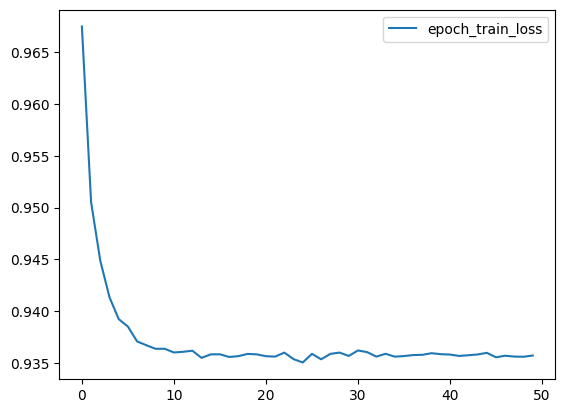

In [68]:
# eval
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    if i + timesteps_to_predict > test_dataset.snapshot_count:
        break

    x_test = snapshot.x.reshape(-1, num_nodes, in_dim).to(device)

    if timesteps_to_predict == 1:
        y_test = snapshot.y.to(device)
    else:
        y_test = y_all[offset+i : offset+i + timesteps_to_predict,:].to(device)


    with torch.no_grad():
        pred = model(x_test, snapshot.edge_index, snapshot.edge_attr).squeeze()
    loss += masked_mse(pred, y_test, 0.0) # mean squared error as loss

loss = loss / (i+1)
loss = loss.item()
print("Test MSE Loss: {:.4f}".format(loss))


# store training loss
df = pd.DataFrame(training_curve_dict)
df.to_csv("training_curve.csv")


# plot training and validation loss
df.plot()

In [ ]:
from google.colab import files
files.download('training_curve.csv')
training_curve_dict["epoch_train_loss"]